# CZII YOLO11 Training Baseline
 We created a training set adapted to YOLO from [the dataset baseline](https://www.kaggle.com/code/itsuki9180/czii-making-datasets-for-yolo).

In this notebook, we actually use it to train YOLO so that it can infer the xy coordinates of particles through 2D object detection.

# Install and Import modules

In [1]:
# !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
# !pip install --no-index --find-links=./packages ultralytics
# !rm -rf ./packages

In [2]:
EXP_NAME = "baseline_cv_syn_data"
LIST_CV = [
    'TS_5_4',
    'TS_69_2',
    'TS_6_4',
    'TS_6_6',
]

PROC_RAW = "proc/yolo11_cv_syn_data_baseline"

PROC = f"../../{PROC_RAW}"
PROC_YAML = f"/workspace/CZII/{PROC_RAW}"

# valデータはもともとのやつ使うのでパス分ける
PROC_VAL_RAW = "proc/yolo11_baseline_cv"

# PROC_VAL = f"../../{PROC_VAL_RAW}"
PROC_VAL_YAML = f"/workspace/CZII/{PROC_VAL_RAW}"

In [3]:
from tqdm import tqdm
import glob, os
from ultralytics import YOLO

# Prepare to train and instance YOLOmodel

In [4]:
yaml_content = f"""
train: {PROC_YAML}/train.txt
val: {PROC_YAML}/val.txt
nc: 6

# Classes
names:
  0: apo-ferritin
  1: beta-amylase
  2: beta-galactosidase
  3: ribosome
  4: thyroglobulin
  5: virus-like-particle
"""

with open(f'{PROC}/cv_conf.yaml', 'w') as f:
    f.write(yaml_content.strip())

# Let's train YOLO!

In [5]:
def list_all_images(root_dir, extensions="png"):
    """指定ディレクトリ以下の画像ファイルパスを再帰的に取得してリストで返す。"""
    all_paths = []
    search_pattern = os.path.join(root_dir, "**", f"*.{extensions}")
    paths = glob.glob(search_pattern, recursive=True)
    all_paths.extend(paths)
    return all_paths

def contains_val_keyword(path, keyword):
    """
    ファイルパスのファイル名に `keyword` が含まれているか確認。
    Trueならval、Falseならtrainとする。
    """
    filename = os.path.basename(path)  # ディレクトリを除いたファイル名を取得
    return keyword in filename

def extract_train_val_paths(keyword):
    # Synthetic data用に変えてある
    train_paths = list_all_images(f"{PROC_YAML}/images")
    train_paths.sort()

    image_paths = list_all_images(f"{PROC_VAL_YAML}/images")
    image_paths.sort()

    val_paths   = []
    # ファイル名をみて振り分け
    for p in image_paths:
        if contains_val_keyword(p, keyword):
            val_paths.append(p)

    print(f"Found {len(train_paths)} train images.")
    print(f"Found {len(val_paths)} val images.")

    # train.txt と val.txt に書き出し
    with open(f"{PROC}/train.txt", "w") as f:
        for path in train_paths:
            f.write(path + "\n")

    with open(f"{PROC}/val.txt", "w") as f:
        for path in val_paths:
            f.write(path + "\n")

    print(f"Train list saved to {f"{PROC}/train.txt"}")
    print(f"Val list saved to {f"{PROC}/val.txt"}")

In [6]:
for cv_name in LIST_CV:
    print("="*100)
    print(f"Processing {cv_name}...")
    extract_train_val_paths(cv_name)

    # Load a pretrained model
    model = YOLO("yolo11l.pt")  # load a pretrained model (recommended for training)

    # Train the model
    _ = model.train(
        data=f"{PROC}/cv_conf.yaml",
        name=EXP_NAME,
        epochs=25,
        warmup_epochs=3,
        optimizer='AdamW',
        cos_lr=True,
        lr0=5e-5,
        lrf=0.01,
        imgsz=640,
        device="0",
        weight_decay=0.01,
        batch=16,
        scale=0,
        flipud=0.5,
        fliplr=0.5,
        degrees=90,
        shear=5,
        mixup=0.2,
        copy_paste=0.25,
        seed=8620, # (｡•◡•｡)
    )

Processing TS_5_4...
Found 5400 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_syn_data_baseline/train.txt
Val list saved to ../../proc/yolo11_cv_syn_data_baseline/val.txt


New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=../../proc/yolo11_cv_syn_data_baseline/cv_conf.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=baseline_cv_syn_data, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=8620, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /workspace/CZII/proc/yolo11_cv_syn_data_baseline/labels... 5400 images, 365 backgrounds, 0 corrupt: 100%|██████████| 5400/5400 [00:33<00:00, 162.52it/s]


train: New cache created: /workspace/CZII/proc/yolo11_cv_syn_data_baseline/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.2' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 184 images, 30 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 121.72it/s]

val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(407d8107f4a24dc4a2c858dfc1a5d8b0) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.404      1.112      1.118        476        640: 100%|██████████| 338/338 [02:29<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        184       2640      0.419      0.277      0.292      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.5G      1.156      0.777     0.9977        403        640: 100%|██████████| 338/338 [02:24<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

                   all        184       2640      0.398      0.432      0.354      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.5G       1.08     0.7156     0.9702        421        640: 100%|██████████| 338/338 [02:20<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       2640      0.373      0.505      0.344      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.4G       1.04     0.6779     0.9564        420        640: 100%|██████████| 338/338 [02:18<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        184       2640      0.399      0.466      0.352      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.3G      1.019     0.6586     0.9481        323        640: 100%|██████████| 338/338 [02:18<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        184       2640      0.397      0.467      0.341      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.4G     0.9885     0.6423     0.9376        386        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        184       2640      0.379      0.427      0.341       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G     0.9774     0.6293     0.9343        456        640: 100%|██████████| 338/338 [02:18<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       2640      0.387      0.449      0.329      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.4G     0.9606     0.6174     0.9285        429        640: 100%|██████████| 338/338 [02:18<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        184       2640      0.376      0.474       0.34      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.4G     0.9557     0.6117     0.9264        442        640: 100%|██████████| 338/338 [02:19<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        184       2640      0.357      0.462       0.34      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.6G     0.9379     0.5996     0.9214        349        640: 100%|██████████| 338/338 [02:21<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        184       2640      0.369      0.446      0.353      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.4G     0.9314     0.5871     0.9189        461        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

                   all        184       2640      0.364      0.402      0.319      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.5G     0.9173     0.5834     0.9147        479        640: 100%|██████████| 338/338 [02:20<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        184       2640      0.395      0.402      0.335      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.4G     0.8957       0.57     0.9092        399        640: 100%|██████████| 338/338 [02:19<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        184       2640      0.379      0.383      0.319      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.2G     0.8756     0.5617     0.9036        464        640: 100%|██████████| 338/338 [02:19<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        184       2640      0.378      0.415      0.335      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.4G     0.8569     0.5517     0.8993        494        640: 100%|██████████| 338/338 [02:18<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

                   all        184       2640      0.375      0.423      0.327      0.219


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25        11G     0.7718     0.4675      0.867        334        640: 100%|██████████| 338/338 [02:19<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        184       2640      0.366      0.402      0.321       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25        11G     0.7525     0.4557     0.8618        355        640: 100%|██████████| 338/338 [02:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       2640      0.384      0.392      0.329      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25        11G     0.7402      0.451     0.8595        288        640: 100%|██████████| 338/338 [02:14<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        184       2640      0.383      0.406      0.334      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.1G     0.7223     0.4447      0.855        326        640: 100%|██████████| 338/338 [02:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        184       2640      0.386      0.427      0.353      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25        11G     0.7107      0.439      0.853        278        640: 100%|██████████| 338/338 [02:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        184       2640      0.397      0.421      0.338      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.1G     0.7022     0.4363     0.8502        288        640: 100%|██████████| 338/338 [02:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        184       2640      0.369      0.425      0.333      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25        11G     0.6979     0.4337     0.8499        254        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        184       2640      0.391      0.419      0.348      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.1G     0.6912      0.431     0.8483        223        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

                   all        184       2640      0.383      0.412      0.339      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25        11G     0.6907     0.4298     0.8476        435        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       2640      0.392      0.419      0.341      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.1G     0.6862     0.4288      0.847        255        640: 100%|██████████| 338/338 [02:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

                   all        184       2640      0.388      0.414       0.34      0.236



25 epochs completed in 0.998 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


                   all        184       2640      0.387      0.427      0.354      0.243
          apo-ferritin        133        506      0.679      0.316      0.439      0.262
    beta-galactosidase        112        200     0.0952       0.27     0.0963     0.0634
              ribosome        145        899      0.365      0.736      0.558      0.387
         thyroglobulin        144        749      0.149      0.285     0.0953      0.062
   virus-like-particle        105        286      0.646      0.528      0.581      0.443
Speed: 0.2ms preprocess, 9.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_69_2...
Found 5400 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_syn_data_baseline/train.txt
Val list saved to ../../proc/yolo11_cv_syn_data_baseline/val.txt
New https:/

train: Scanning /workspace/CZII/proc/yolo11_cv_syn_data_baseline/labels.cache... 5400 images, 365 backgrounds, 0 corrupt: 100%|██████████| 5400/5400 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 184 images, 82 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 181.45it/s]

val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data2/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(a935e21fafdc4c9abff0b9fcc89b7a86) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25        12G      1.402      1.109      1.118        476        640: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

                   all        184       2814      0.332      0.452      0.347      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      12.1G      1.157     0.7781     0.9976        403        640: 100%|██████████| 338/338 [02:29<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        184       2814      0.427      0.447      0.394       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      12.2G      1.084     0.7164     0.9711        421        640: 100%|██████████| 338/338 [02:26<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        184       2814      0.459      0.463      0.391      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25        12G      1.041     0.6779     0.9564        420        640: 100%|██████████| 338/338 [02:23<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        184       2814      0.429      0.473      0.392      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25        12G       1.02      0.658     0.9482        323        640: 100%|██████████| 338/338 [02:24<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        184       2814      0.438       0.43      0.361      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      12.1G     0.9873     0.6434     0.9376        386        640: 100%|██████████| 338/338 [02:24<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       2814      0.433      0.452      0.374      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      12.2G     0.9793      0.629      0.935        456        640: 100%|██████████| 338/338 [02:24<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        184       2814      0.468      0.443      0.404       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25        12G      0.963      0.618      0.929        429        640: 100%|██████████| 338/338 [02:23<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        184       2814      0.432       0.45      0.395      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25        12G     0.9566     0.6077     0.9267        442        640: 100%|██████████| 338/338 [02:23<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2814      0.449      0.403      0.382      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      12.3G     0.9404     0.5981     0.9219        349        640: 100%|██████████| 338/338 [02:24<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        184       2814      0.445      0.449        0.4      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      12.1G     0.9355     0.5892     0.9198        461        640: 100%|██████████| 338/338 [02:24<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        184       2814      0.493      0.425      0.417      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      12.1G     0.9204      0.584     0.9157        479        640: 100%|██████████| 338/338 [02:24<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        184       2814      0.484      0.422      0.404      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      12.1G     0.9085     0.5744     0.9123        399        640: 100%|██████████| 338/338 [02:24<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2814      0.474      0.435      0.413      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.9G     0.8906     0.5655      0.907        464        640: 100%|██████████| 338/338 [02:24<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2814      0.462      0.448      0.415      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25        12G     0.8713      0.556     0.9027        494        640: 100%|██████████| 338/338 [02:23<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

                   all        184       2814      0.481      0.433      0.417      0.282


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.7G     0.7713     0.4695     0.8669        334        640: 100%|██████████| 338/338 [02:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       2814      0.486       0.45      0.429      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.7G     0.7418     0.4572     0.8596        355        640: 100%|██████████| 338/338 [02:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        184       2814       0.47      0.454       0.42      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.7G     0.7281     0.4496     0.8567        288        640: 100%|██████████| 338/338 [02:21<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        184       2814      0.443      0.458      0.417      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.7G      0.713     0.4441      0.853        326        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        184       2814       0.45      0.462      0.416      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.7G     0.7046     0.4397     0.8515        278        640: 100%|██████████| 338/338 [02:19<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

                   all        184       2814      0.452      0.459       0.42      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.7G     0.6953     0.4354     0.8488        288        640: 100%|██████████| 338/338 [02:19<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

                   all        184       2814      0.459      0.449      0.418      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G     0.6883     0.4321     0.8479        254        640: 100%|██████████| 338/338 [02:18<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

                   all        184       2814      0.472      0.454      0.423      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.7G     0.6814     0.4294     0.8465        223        640: 100%|██████████| 338/338 [02:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        184       2814      0.444       0.47      0.411      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.7G     0.6811      0.428     0.8459        435        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        184       2814      0.448      0.467      0.412      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.7G     0.6755     0.4266     0.8451        255        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        184       2814      0.442      0.477      0.414      0.284



25 epochs completed in 1.025 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data2/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data2/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data2/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


                   all        184       2814      0.472      0.454      0.423      0.293
          apo-ferritin         75        385      0.519      0.414      0.411      0.254
    beta-galactosidase         86        272      0.114       0.21     0.0825     0.0455
              ribosome         96       1073      0.636      0.822      0.774      0.541
         thyroglobulin        100        850      0.189      0.236      0.103     0.0633
   virus-like-particle         56        234      0.902      0.588      0.743      0.559
Speed: 0.2ms preprocess, 27.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data2
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_4...
Found 5400 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_syn_data_baseline/train.txt
Val list saved to ../../proc/yolo11_cv_syn_data_baseline/val.txt
New https:

train: Scanning /workspace/CZII/proc/yolo11_cv_syn_data_baseline/labels.cache... 5400 images, 365 backgrounds, 0 corrupt: 100%|██████████| 5400/5400 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 184 images, 39 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 139.58it/s]

val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data3/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(b481b41900924576a19b6862a122778c) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25        12G      1.405      1.104      1.119        476        640: 100%|██████████| 338/338 [02:31<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       3998      0.367      0.309      0.295      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      12.1G      1.163     0.7796      1.001        403        640: 100%|██████████| 338/338 [02:22<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       3998      0.403      0.424      0.342      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      12.2G      1.099     0.7241     0.9748        421        640: 100%|██████████| 338/338 [02:19<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       3998      0.356      0.381      0.313      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25        12G      1.058     0.6882     0.9606        420        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        184       3998       0.39      0.425      0.329      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25        12G       1.03      0.663     0.9507        323        640: 100%|██████████| 338/338 [02:18<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        184       3998       0.41      0.453      0.358      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      12.1G     0.9939     0.6441       0.94        386        640: 100%|██████████| 338/338 [02:19<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        184       3998      0.364      0.419      0.321      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      12.2G     0.9852     0.6336     0.9373        456        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

                   all        184       3998       0.36      0.416      0.311      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25        12G      0.966     0.6205     0.9304        429        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        184       3998      0.356      0.387      0.302      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25        12G     0.9634     0.6081     0.9291        442        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       3998      0.355       0.39      0.324      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      12.3G      0.951     0.6028     0.9256        349        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        184       3998      0.359      0.375      0.325      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25        12G     0.9436     0.5924     0.9225        461        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       3998      0.376      0.376      0.326      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      12.1G     0.9346     0.5878     0.9196        479        640: 100%|██████████| 338/338 [02:18<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       3998      0.338      0.355      0.299      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      12.1G     0.9305     0.5809     0.9184        399        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.403      0.353       0.31      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.9G     0.9188     0.5737     0.9142        464        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       3998      0.372      0.368      0.324      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      12.1G     0.9139     0.5677     0.9129        494        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3998      0.409      0.358      0.317      0.227


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.7G     0.8363      0.485     0.8819        334        640: 100%|██████████| 338/338 [02:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       3998      0.351      0.385      0.318      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.7G     0.8262     0.4759     0.8789        355        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       3998      0.355      0.412      0.325      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.7G     0.8149     0.4712     0.8764        288        640: 100%|██████████| 338/338 [02:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        184       3998      0.364       0.41       0.33      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.7G     0.8012     0.4648     0.8726        326        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       3998      0.372       0.43      0.338      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.7G     0.7845     0.4591     0.8693        278        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.355      0.388      0.319      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.7G     0.7592     0.4528     0.8628        288        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       3998      0.372      0.412      0.336      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G       0.74      0.447     0.8594        254        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        184       3998      0.403      0.412      0.344       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.7G     0.7286     0.4435      0.857        223        640: 100%|██████████| 338/338 [02:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       3998      0.401      0.406      0.339      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.7G     0.7247     0.4399     0.8555        435        640: 100%|██████████| 338/338 [02:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       3998      0.401      0.436      0.348      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.7G     0.7203     0.4383     0.8548        255        640: 100%|██████████| 338/338 [02:14<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3998      0.395      0.436      0.347      0.241



25 epochs completed in 0.990 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data3/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data3/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data3/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


                   all        184       3998      0.401      0.436      0.348      0.242
          apo-ferritin        121        638      0.616      0.467      0.506      0.332
    beta-galactosidase         89        204     0.0508     0.0931     0.0158    0.00718
              ribosome        129       2146      0.534      0.867      0.632      0.425
         thyroglobulin        125        750      0.139      0.293     0.0908     0.0525
   virus-like-particle         75        260      0.663      0.458      0.494      0.392
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data3
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_6...
Found 5400 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_syn_data_baseline/train.txt
Val list saved to ../../proc/yolo11_cv_syn_data_baseline/val.txt
New https:/

train: Scanning /workspace/CZII/proc/yolo11_cv_syn_data_baseline/labels.cache... 5400 images, 365 backgrounds, 0 corrupt: 100%|██████████| 5400/5400 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 184 images, 24 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 177.50it/s]

val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data4/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(b5d50bcce73346e496f1f211dcf125e9) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25        12G      1.413       1.13      1.123        476        640: 100%|██████████| 338/338 [02:30<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        184       2674       0.42      0.452      0.374      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      12.1G      1.164     0.7745      1.001        403        640: 100%|██████████| 338/338 [02:22<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        184       2674      0.413      0.501      0.407      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      12.2G      1.093     0.7199      0.973        421        640: 100%|██████████| 338/338 [02:20<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       2674      0.393      0.526      0.368      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25        12G      1.055     0.6862     0.9593        420        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       2674      0.407      0.492      0.388      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25        12G      1.031     0.6628     0.9501        323        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.374      0.444      0.349      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      12.1G     0.9959     0.6455     0.9394        386        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.419      0.432      0.364      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      12.2G     0.9875     0.6329     0.9371        456        640: 100%|██████████| 338/338 [02:18<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       2674      0.418      0.472      0.387      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25        12G     0.9683     0.6198     0.9299        429        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.436      0.473       0.39      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25        12G     0.9657     0.6104     0.9291        442        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.411      0.449      0.371      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      12.3G     0.9518     0.6003     0.9247        349        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.444      0.478        0.4      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      12.1G     0.9454     0.5936     0.9222        461        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       2674      0.461      0.441      0.396      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      12.1G     0.9356      0.588     0.9191        479        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2674      0.455      0.455      0.393      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      12.1G     0.9292     0.5808     0.9173        399        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.448      0.487      0.417       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.9G     0.9233     0.5747     0.9148        464        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.439      0.455      0.397      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25        12G     0.9171     0.5676      0.913        494        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2674      0.427      0.446       0.38      0.249


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.7G      0.841     0.4898     0.8823        334        640: 100%|██████████| 338/338 [02:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       2674      0.448      0.444        0.4      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.7G     0.8314     0.4784     0.8792        355        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       2674      0.433      0.448      0.395      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.7G     0.8127     0.4728     0.8751        288        640: 100%|██████████| 338/338 [02:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       2674      0.435      0.444      0.392      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.7G     0.7713     0.4606     0.8653        326        640: 100%|██████████| 338/338 [02:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       2674      0.451      0.437      0.389      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.7G     0.7485     0.4535     0.8609        278        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674       0.45      0.441      0.395      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.7G     0.7354     0.4479      0.857        288        640: 100%|██████████| 338/338 [02:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.459      0.427      0.391       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G     0.7245     0.4433     0.8554        254        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.465      0.428      0.394      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.7G     0.7166     0.4411     0.8536        223        640: 100%|██████████| 338/338 [02:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.458      0.426      0.393      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.7G     0.7153     0.4385     0.8529        435        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674       0.46      0.428      0.392      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.7G     0.7123      0.438     0.8525        255        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.465      0.424       0.39      0.239



25 epochs completed in 1.012 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data4/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data4/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data4/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


                   all        184       2674      0.449      0.487      0.417       0.28
          apo-ferritin        149        451      0.595       0.45      0.458      0.265
    beta-galactosidase         84        187     0.0591      0.193     0.0335     0.0201
              ribosome        106        667      0.536      0.855      0.677      0.424
         thyroglobulin        144        875      0.211      0.282      0.129     0.0797
   virus-like-particle        127        494      0.841      0.655      0.788      0.613
Speed: 0.6ms preprocess, 28.9ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data4
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [7]:
# model = YOLO(f"../../runs/detect/{EXP_NAME}/weights/best.pt")
# metrics = model.val(data=f"{PROC}/czii_conf.yaml", imgsz=640, batch=16, conf=0.25, iou=0.6, device="0", save_json=True)  # no arguments needed, dataset and settings remembered
# print(metrics.box.map)  # map50-95
# print(metrics.box.map50)  # map50
# print(metrics.box.map75)  # map75
# print(metrics.box.maps)

# Prediction example

In [8]:
import pandas as pd
from IPython.display import display, HTML
from IPython.display import Image as IPyImage
pd.options.display.precision = 3

columns = [
    "metrics/precision(B)",
    "metrics/recall(B)",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
]
df_result = pd.DataFrame(columns=columns)
for i in range(len(LIST_CV)):
    if i == 0:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}/results.csv")
    else:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}{i+1}/results.csv")
    
    list_results = [
        df.iloc[-1]["metrics/precision(B)"],
        df.iloc[-1]["metrics/recall(B)"],
        df.iloc[-1]["metrics/mAP50(B)"],
        df.iloc[-1]["metrics/mAP50-95(B)"],
    ]
    df_result.loc[f"val_{LIST_CV[i]}"] = list_results
df_result.loc["mean"] = df_result.mean()
df_result

,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
val_TS_5_4,0.388,0.414,0.340,0.236
val_TS_69_2,0.442,0.477,0.414,0.284
val_TS_6_4,0.395,0.436,0.347,0.241
val_TS_6_6,0.465,0.424,0.390,0.239
mean,0.422,0.438,0.373,0.250


In [9]:
# 画像を2x2のグリッドで表示
html_content = '''
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
</div>
'''.format(
    EXP_NAME,
    f"{EXP_NAME}2",
    f"{EXP_NAME}3",
    f"{EXP_NAME}4"
)

display(HTML(html_content))

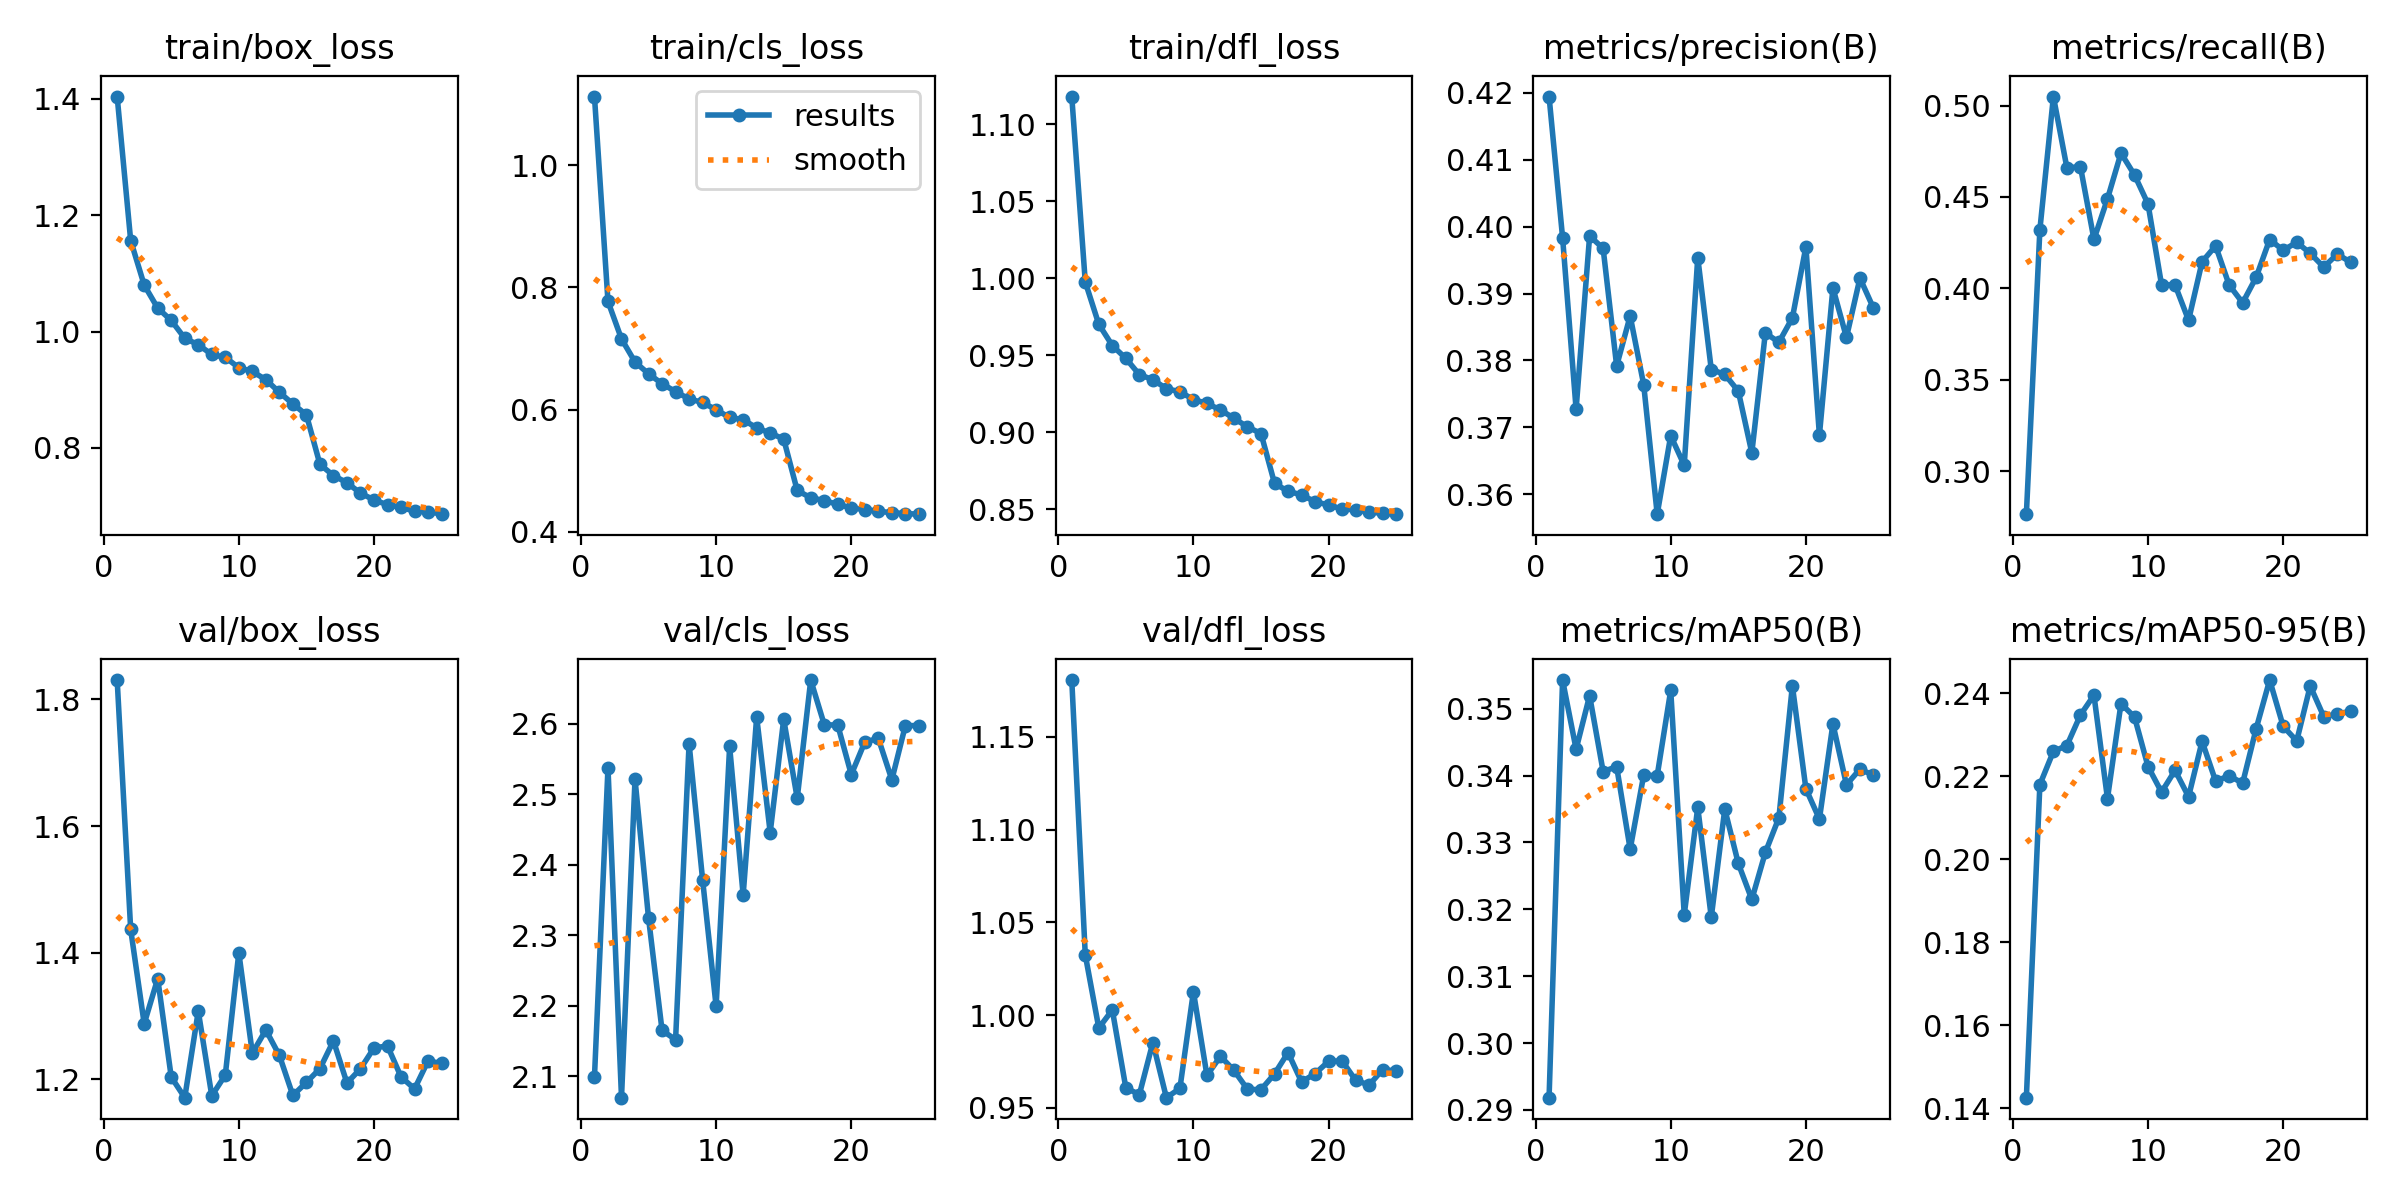

In [10]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}/results.png', width=800)